
# Colored MNIST example


The coloring is taken from https://colab.research.google.com/github/reiinakano/invariant-risk-minimization/blob/master/invariant_risk_minimization_colored_mnist.ipynb


# Imports

In [1]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms

# Utilities

In [2]:
def color_grayscale_arr(arr, color):
    """Converts grayscale image to either red or green"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if color == 'red':
        arr = np.concatenate([arr, np.zeros((h, w, 2), dtype=dtype)], axis=2)
    elif color == 'green':
        arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype), arr, np.zeros((h, w, 1), dtype=dtype)], axis=2)
    else:  # color == 'blue':
        arr = np.concatenate([np.zeros((h, w, 2), dtype=dtype), arr], axis=2)
    return arr


class ColoredMNIST(datasets.VisionDataset):
    """
    Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

    Args:
      root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
      env (string): Which environment to load. Must be 1 of 'train1', 'train2', 'test', or 'all_train'.
      transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.RandomCrop``
      target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
    """

    def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
        super(ColoredMNIST, self).__init__(root, transform=transform,
                                           target_transform=target_transform)
        self.env = env
        self.prepare_colored_mnist()
        if env in ['train', 'test']:
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
        elif env == 'all':
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train.pt')) + torch.load(os.path.join(self.root, 'ColoredMNIST', 'test.pt'))
        else:
            raise RuntimeError(f'{env} env unknown. Valid envs are train, test, and all')

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, color_label, digit_label = self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        return img, color_label, digit_label

    def __len__(self):
        return len(self.data_label_tuples)

    def prepare_colored_mnist(self):
        colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
        if os.path.exists(os.path.join(colored_mnist_dir, 'train.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
            print('Colored MNIST dataset already exists')
            return

        print('Preparing Colored MNIST')
        if self.env == 'train':
            dataset = datasets.mnist.MNIST(self.root, train=True, download=True)
        elif self.env == 'test':
            dataset = datasets.mnist.MNIST(self.root, train=False, download=True)

        data_set = []

        for idx, (im, label) in enumerate(dataset):
            if idx % 10000 == 0:
                print(f'Converting train image {idx}/{len(dataset)}')
            im_array = np.array(np.squeeze(im))
            # Assign a random label
            ternary_label = np.random.randint(3)
            # Color the image
            if ternary_label == 0:
                color = 'red'
            elif ternary_label == 1:
                color = 'green'
            else:
                color = 'blue'
            colored_arr = color_grayscale_arr(im_array, color=color)
            data_set.append((Image.fromarray(colored_arr), ternary_label, label))
        path = Path(colored_mnist_dir)
        path.mkdir(exist_ok=True)
        torch.save(data_set, os.path.join(colored_mnist_dir, self.env + '.pt'))


def plot_dataset_digits(dataset):
    fig = plt.figure(figsize=(13, 8))
    columns = 6
    rows = 3
    # ax enables access to manipulate each of subplots
    ax = []
    for i in range(columns * rows):
        ind = np.random.randint(len(dataset))
        img, color_label, digit_label = dataset[ind]
        # create subplot and append to ax
        ax.append(fig.add_subplot(rows, columns, i + 1))
        ax[-1].set_title("labels: " + str(color_label) + ', ' + str(digit_label))  # set title
        plt.imshow(img.permute(1, 2, 0))

    plt.show()  # finally, render the plot

##  Input arguments:

In [3]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--batch_size',       type=int, default=128, help='Batch size (default=128)')
parser.add_argument('--beta_rf',          type=float, default=1e-3, help='real/fake disc loss coefficient')
parser.add_argument('--beta_ind',         type=float, default=1e-2, help='independence disc loss coefficient')
parser.add_argument('--ae_lr',            type=float, default=1e-3, help='learning_rate for ae (default=1e-3)')
parser.add_argument('--d_lr',             type=float, default=1e-4, help='learning_rate for discriminators optimizers (use 1e-4 if FLAGS.loss == ''cca'')')
parser.add_argument("--min_lr",           type=float,default=1e-5,help="Minimal learning rate")
parser.add_argument("--decay_step_size",  type=int,default=45, help="LR decay step size")
parser.add_argument("--lr_decay_factor",  type=float,default=0.1,help="LR decay factor")
parser.add_argument("--weight_decay",     type=float, default=1e-4,help="l_2 weight penalty")
parser.add_argument("--n_epochs",         type=int,default=50,help="Number of epochs without improvement before stopping")
parser.add_argument("--train_discs_every",type=int,default=1, help="Train discriminators every this number of epochs")
parser.add_argument("--train_ae_every",   type=int,default=5,help="Train autoencoder every this number of epochs")
parser.add_argument("--apply_r1_every",   type=int,default=16, help="Apply R1 regularization every this number of epochs")
parser.add_argument("--label",            type=str,default='digit', help="color | digit")

FLAGS = parser.parse_args(args=[])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Datasets:

Preparing Colored MNIST


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Converting train image 0/60000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Converting train image 10000/60000
Converting train image 20000/60000
Converting train image 30000/60000
Converting train image 40000/60000
Converting train image 50000/60000
Preparing Colored MNIST
Converting train image 0/10000


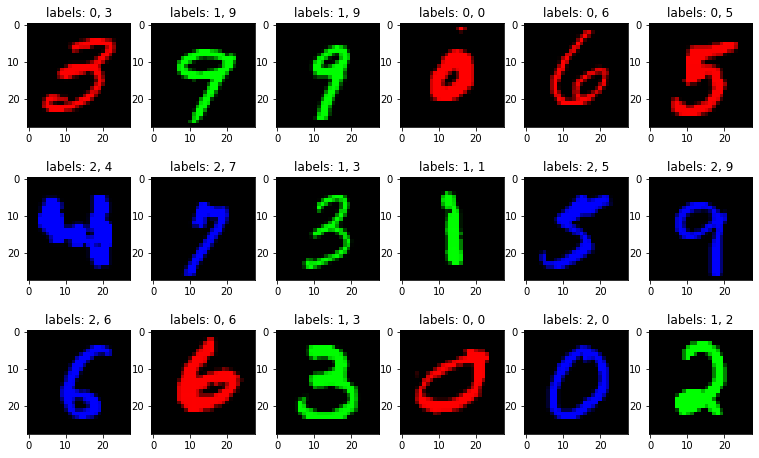

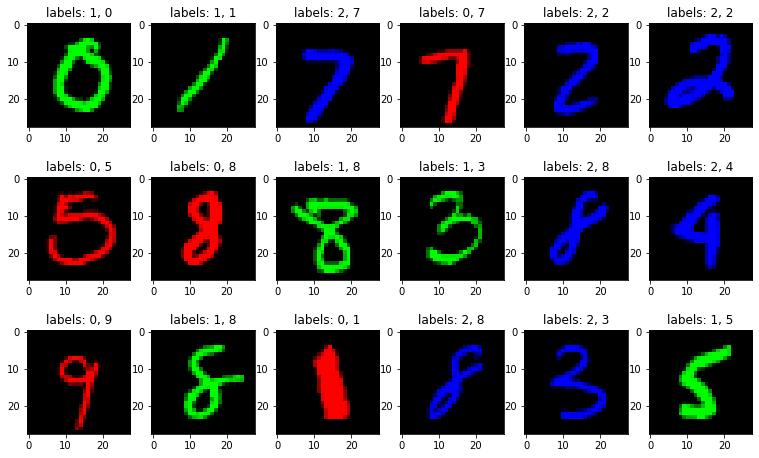

In [4]:
norm_mean = [.5, .5, .5]
norm_std = [.5, .5, .5]

def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


def plot_dataset_digits(dataset):
    fig = plt.figure(figsize=(13, 8))
    columns = 6
    rows = 3
    ax = []
  
    for i in range(columns * rows):
        ind = np.random.randint(len(dataset))  
        img, color_label, digit_label = dataset[ind]
        img = inverse_normalize(img, mean=norm_mean, std=norm_std)  
        ax.append(fig.add_subplot(rows, columns, i + 1))
        ax[-1].set_title("labels: " + str(color_label) + ', ' + str(digit_label))  # set title
        plt.imshow(img.permute(1, 2, 0))

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean,
                         std=norm_std),
    ])

train_data = ColoredMNIST(root='./data', 
                          env='train',
                          transform=transform)

plot_dataset_digits(train_data) 

test_data = ColoredMNIST(root='./data', 
                          env='test',
                          transform=transform)

plot_dataset_digits(test_data) 

train_kwargs = {'batch_size': FLAGS.batch_size}
test_kwargs = {'batch_size': FLAGS.batch_size}

train_loader = torch.utils.data.DataLoader(train_data,**train_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **test_kwargs)

input_dim = 3 * 28 ** 2

n_digit_classes = 10
n_color_classes = 3
if FLAGS.label == 'color':
    n_classes = n_color_classes
elif FLAGS.label == 'digit':
    n_classes = n_digit_classes
    

# Functions required for modulation layer 

(taken from https://github.com/taesungp/swapping-autoencoder-pytorch/)

In [5]:
def fused_leaky_relu(input, bias, negative_slope=0.2, scale=2 ** 0.5):
    global use_custom_kernel
    if use_custom_kernel:
        return FusedLeakyReLUFunction.apply(input, bias, negative_slope, scale)
    else:
        dims = [1, -1] + [1] * (input.dim() - 2)
        bias = bias.view(*dims)
        return F.leaky_relu(input + bias, negative_slope) * scale

class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=1, activation=None):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))
        else:
            self.bias = None
        self.activation = activation
        self.scale = (1 / math.sqrt(in_dim)) * lr_mul
        self.lr_mul = lr_mul

    def forward(self, input):
        if self.activation:
            if input.dim() > 2:
                out = F.conv2d(input, self.weight[:, :, None, None] * self.scale)
            else:
                out = F.linear(input, self.weight * self.scale)
            out = fused_leaky_relu(out, self.bias * self.lr_mul)
        else:
            if input.dim() > 2:
                out = F.conv2d(input, self.weight[:, :, None, None] * self.scale, bias=self.bias * self.lr_mul)
            else:
                out = F.linear(input, self.weight * self.scale, bias=self.bias * self.lr_mul)
        return out

    def __repr__(self):
        return (f'{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]})')

class GeneratorModulation(torch.nn.Module):
    def __init__(self, styledim, outch):
        super().__init__()
        self.scale = EqualLinear(styledim, outch)
        self.bias = EqualLinear(styledim, outch)

    def forward(self, x, style):
        if style.ndimension() <= 2:
            return x * (1 * self.scale(style)[:, :, None, None]) + self.bias(style)[:, :, None, None]
        else:
            style = F.interpolate(style, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
            return x * (1 * self.scale(style)) + self.bias(style)
            

# Models

In [6]:
class Encoder(nn.Module):   
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(Encoder, self).__init__()
        use_bias = norm_layer != nn.BatchNorm2d
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, stride=2, bias=use_bias)  
        # conv layer (depth from 16 --> 32), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, stride=2, bias=use_bias)
        # conv layer (depth from 32 --> 64), 7x7 kernels
        self.conv3 = nn.Conv2d(32, 64, 7, bias=use_bias)
        self.norm1 = norm_layer(16)
        self.norm2 = norm_layer(32)
        self.norm3 = norm_layer(64)
        self.activation = nn.ReLU()
       
    def forward(self, x):
        x = self.activation(self.norm1(self.conv1(x)))
        x = self.activation(self.norm2(self.conv2(x)))
        x = self.activation(self.norm3(self.conv3(x)))
        code = x
        return code
        
class Decoder(nn.Module):   
    def __init__(self, norm_layer=nn.InstanceNorm2d, label_embedding_dim=64):
        super(Decoder, self).__init__()
        use_bias = norm_layer != nn.BatchNorm2d
        self.activation = nn.ReLU()
        self.label_embeddings = nn.Embedding(n_classes, embedding_dim=label_embedding_dim)
        self.modulation1 = GeneratorModulation(styledim=label_embedding_dim, outch=64)
        self.t_conv1 = nn.ConvTranspose2d(64 , 32, 7, bias=use_bias)
        self.modulation2 = GeneratorModulation(styledim=label_embedding_dim, outch=32)
        self.t_conv2 = nn.ConvTranspose2d(32, 16, 2, stride=2, bias=use_bias)
        self.modulation3 = GeneratorModulation(styledim=label_embedding_dim, outch=16)
        self.t_conv3 = nn.ConvTranspose2d(16, 3, 2, stride=2)
        self.norm1 = norm_layer(32)
        self.norm2 = norm_layer(16)
                
    def forward(self, x, y):
        """
        Style is applied via modulation before every layer
        """
        style = self.label_embeddings(y)
        # modulate x
        x = self.modulation1(x, style)
        # add transpose conv layers, with relu activation function
        x = self.activation(self.norm1(self.t_conv1(x)))
        # modulate x
        x = self.modulation2(x, style)
        x = self.activation(self.norm2(self.t_conv2(x)))
        # modulate x
        x = self.modulation3(x, style)
        x = self.t_conv3(x)
        x = nn.Tanh()(x)
        return x

class Ind_Discriminator(nn.Module):   
    def __init__(self, norm_layer=nn.BatchNorm1d):
        super(Ind_Discriminator, self).__init__()
        self.activation=nn.LeakyReLU()
        self.out_dim=n_classes
        use_bias = norm_layer != nn.BatchNorm1d
         # Layers
        self.layer1 = nn.Sequential(
            nn.Linear(64, 128, bias=use_bias),
            norm_layer(128),
            self.activation,
        )
        self.layer2 = nn.Sequential(
            nn.Linear(128, 128, bias=use_bias),
            norm_layer(128),
            self.activation,
        )
        self.layer3 = nn.Sequential(nn.Linear(128, self.out_dim))
             
    def forward(self, code):
        """
        Code goes through standard forward pass, model outputs mapped code and label embedding
        """
        x = torch.flatten(code, 1)
        x = self.layer1(x)
        x = x + self.layer2(x)
        x = self.layer3(x)
        return x 

class RF_Discriminator(nn.Module):   
    def __init__(self, norm_layer=nn.BatchNorm2d):
        
        super(RF_Discriminator, self).__init__()
        use_bias = norm_layer != nn.BatchNorm2d
        self.label_embeddings = nn.Parameter(torch.randn(n_classes, 1, 28, 28))
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(4, 16, 3, padding=1, stride=2, bias=use_bias)  
        # conv layer (depth from 16 --> 32), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, stride=2, bias=use_bias)
        # conv layer (depth from 32 --> 64), 7x7 kernels
        self.conv3 = nn.Conv2d(32, 64, 7, bias=use_bias)
        self.norm1 = norm_layer(16)
        self.norm2 = norm_layer(32)
        self.norm3 = norm_layer(64)
        self.activation = nn.ReLU()
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x, y):
        """
        Standard forward
        """
        o = self.label_embeddings[y]
        x = torch.cat([x, o], dim=1)
        x = self.activation(self.norm1(self.conv1(x)))
        x = self.activation(self.norm2(self.conv2(x)))
        x = self.activation(self.norm3(self.conv3(x)))
        x = nn.Flatten()(x)
        out = torch.sigmoid(self.fc1(x))
        return out
    
encoder = Encoder()
decoder = Decoder()
ind_discriminator = Ind_Discriminator()
rf_discriminator = RF_Discriminator()
       
encoder.to(device=device)
decoder.to(device=device)
ind_discriminator.to(device=device)
rf_discriminator.to(device=device)


RF_Discriminator(
  (conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)

# Loss criterions

In [7]:
recon_criterion = nn.BCELoss()
rf_criterion = nn.BCELoss()
ind_criterion = nn.CrossEntropyLoss()

def indep_loss(logits, y, should_be_dependent=True):
    if should_be_dependent:
        return ind_criterion(logits, y)  
    else: 
        return -ind_criterion(logits, y) 

def gan_loss (x, should_be_classified_as_real=True):
    x = torch.clamp(x, min=1e-7, max=1 - 1e-7)
    if should_be_classified_as_real:
        label = torch.full((x.size(0), 1), 1., dtype=torch.float, device=device)
    else: 
        label = torch.full((x.size(0), 1), 0., dtype=torch.float, device=device)
    return rf_criterion(x, label)

def compute_rf_R1_loss(model, x, y):
    x = x.detach().clone()
    x.requires_grad_()
    pred_real = model(x, y).sum()
    grad_real, = torch.autograd.grad(
        outputs=pred_real,
        inputs=[x],
        create_graph=True,
        retain_graph=True,
    )
    grad_real2 = grad_real.pow(2)
    dims = list(range(1, grad_real2.ndim))
    grad_penalty = grad_real2.sum(dims) * 0.5

    return grad_penalty.sum()


# Optimizers and LR

In [8]:
def lambda_rule(epoch) -> float:
  """ stepwise learning rate calculator """
  exponent = int(np.floor((epoch + 1) / FLAGS.decay_step_size))
  return np.power(FLAGS.lr_decay_factor, exponent)

def update_lr(optim, scheduler):
  """ Learning rate updater """
  scheduler.step()
  lr = optim.param_groups[0]['lr']
  if lr < FLAGS.min_lr:
      optim.param_groups[0]['lr'] = FLAGS.min_lr
      lr = optim.param_groups[0]['lr']
  print('Learning rate = %.7f' % lr) 

ae_optim = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),
                            lr=FLAGS.ae_lr, 
                            betas=(0.5, 0.999),
                            weight_decay=FLAGS.weight_decay)

ind_disc_optim = torch.optim.Adam(ind_discriminator.parameters(), 
                                 lr=FLAGS.d_lr, 
                                 betas=(0.5, 0.999),
                                 weight_decay=FLAGS.weight_decay) 

rf_disc_optim = torch.optim.Adam(rf_discriminator.parameters(), 
                                 lr=FLAGS.d_lr, 
                                 betas=(0.5, 0.999),
                                 weight_decay=FLAGS.weight_decay)

ae_sched = lr_scheduler.LambdaLR(ae_optim, lr_lambda=lambda_rule) 

ind_disc_sched = lr_scheduler.LambdaLR(ind_disc_optim, lr_lambda=lambda_rule)  

rf_disc_sched = lr_scheduler.LambdaLR(rf_disc_optim, lr_lambda=lambda_rule)     

# Training

In [9]:
def train():

    for epoch in range(FLAGS.n_epochs):
        
        encoder.train(True) 
        decoder.train(True) 
        ind_discriminator.train(True)    
        rf_discriminator.train(True)    
        
        recon_losses = []
        indep_losses = []
        rf_losses = []
        

        for step, (batch_x, batch_color, batch_digit) in enumerate(train_loader):
            
            if FLAGS.label == 'color':
                batch_y = batch_color
            elif FLAGS.label == 'digit':
                batch_y = batch_digit
            
            batch_x = batch_x.float().to(device=device)
            batch_y = batch_y.to(device=device)
            
            if step % FLAGS.train_discs_every == 0:
                ind_discriminator.zero_grad()
                rf_discriminator.zero_grad()
                label = nn.functional.one_hot(batch_y, num_classes=n_classes).float()

                code = encoder(batch_x) 
                
                logits = ind_discriminator(code.detach())
                ind_discriminator_loss = indep_loss(logits, batch_y, should_be_dependent=True) 
                    
                code = encoder(batch_x)
                n1 = batch_x.size(0) // 2
                code_for_recon = code[:n1]
                batch_y_for_recon = batch_y[:n1]

                code_for_swap = code[n1:]
                batch_y_for_swap = batch_y[n1:]
                p = np.random.permutation(batch_y_for_swap.size(0))
                batch_y_for_swap = batch_y_for_swap[p]

                recon = decoder(code_for_recon, batch_y_for_recon)
                swap = decoder(code_for_swap, batch_y_for_swap)
                
                rf_disc_real_out = rf_discriminator(batch_x, batch_y)
                rf_disc_recon_out = rf_discriminator(recon.detach(), batch_y_for_recon)
                rf_disc_swap_out = rf_discriminator(swap.detach(), batch_y_for_swap)

                recon_loss = recon_criterion((recon + 1.) / 2., (batch_x[:n1] + 1.) / 2.) 
                rf_loss_real = gan_loss(rf_disc_real_out, should_be_classified_as_real=True)
                rf_loss_fake_r = gan_loss(rf_disc_recon_out, should_be_classified_as_real=False)
                rf_loss_fake_s = gan_loss(rf_disc_swap_out, should_be_classified_as_real=False)
                rf_discriminator_loss = rf_loss_real + 0.5 * rf_loss_fake_r + .5 * rf_loss_fake_s

                ind_discriminator_loss.backward()
                rf_discriminator_loss.backward()

                ind_disc_optim.step()
                rf_disc_optim.step() 
            
            if step % FLAGS.apply_r1_every == 0:
                # r1 losses 
                rf_discriminator.zero_grad()
                rf_disc_r1_loss = compute_rf_R1_loss(rf_discriminator, batch_x, batch_y)
                rf_disc_r1_loss.backward()
                rf_disc_optim.step()
            
            if step % FLAGS.train_ae_every == 0:
                # train AE
                encoder.zero_grad()
                decoder.zero_grad()
                
                label = nn.functional.one_hot(batch_y, num_classes=n_classes).float()

                code = encoder(batch_x)
                logits = ind_discriminator(code)
                independence_loss = indep_loss(logits, batch_y, should_be_dependent=False) 
                code = encoder(batch_x)
                n1 = batch_x.size(0) // 2
                code_for_recon = code[:n1]
                batch_y_for_recon = batch_y[:n1]

                code_for_swap = code[n1:]
                batch_y_for_swap = batch_y[n1:]
                p = np.random.permutation(batch_y_for_swap.size(0))
                batch_y_for_swap = batch_y_for_swap[p]

                recon = decoder(code_for_recon, batch_y_for_recon)
                swap = decoder(code_for_swap, batch_y_for_swap)
                
                rf_disc_recon_out = rf_discriminator(recon, batch_y_for_recon)
                rf_disc_swap_out = rf_discriminator(swap, batch_y_for_swap)
                
                recon_loss = recon_criterion((recon + 1.) / 2., (batch_x[:n1] + 1.) / 2.)   
                rf_loss_fake_r = gan_loss(rf_disc_recon_out, should_be_classified_as_real=True)
                rf_loss_fake_s = gan_loss(rf_disc_swap_out, should_be_classified_as_real=True)
                rf_loss = rf_loss_fake_r + rf_loss_fake_s
                
                                
                ae_loss = recon_loss + FLAGS.beta_ind * independence_loss + FLAGS.beta_rf * rf_loss
                ae_loss.backward()
                ae_optim.step()
                
                recon_losses.append(recon_loss.item())
                indep_losses.append(independence_loss.item())
                rf_losses.append(rf_loss.item())
                
                if step % 10 == 0:
                    print('Epoch: {}/{}, Step: {}'.format(epoch + 1, FLAGS.n_epochs, step))
                    print('Recon_loss: {:.3f}, indep loss:  {:.3f}, rf loss: {:.3f}'.format(np.mean(recon_losses),
                                                                                              np.mean(indep_losses),
                                                                                              np.mean(rf_losses)))
                    
                    print('Learning rate = %.7f' % ae_optim.param_groups[0]['lr'])        
        
    print('Finished training ')
    
def test():    
    print('Running test')
    encoder.train(False) 
    decoder.train(False) 
    ind_discriminator.train(False)    
    rf_discriminator.train(False) 
    
    test_recon_losses = []
    test_indep_losses = []
    test_rf_losses = []
   
    for (batch_x, batch_color, batch_digit) in test_loader:
        if FLAGS.label == 'color':
            batch_y = batch_color
        elif FLAGS.label == 'digit':
            batch_y = batch_digit
            
        batch_x = batch_x.float().to(device=device)
        batch_y = batch_y.to(device=device)
              
        label = nn.functional.one_hot(batch_y, num_classes=n_classes).float()
        code = encoder(batch_x)
        logits = ind_discriminator(code)
        independence_loss = indep_loss(logits, batch_y, should_be_dependent=False) 
        
        code = encoder(batch_x)
        n1 = batch_x.size(0) // 2
        code_for_recon = code[:n1]
        batch_y_for_recon = batch_y[:n1]

        code_for_swap = code[n1:]
        batch_y_for_swap = batch_y[n1:]
        p = np.random.permutation(batch_y_for_swap.size(0))
        batch_y_for_swap = batch_y_for_swap[p]

        recon = decoder(code_for_recon, batch_y_for_recon)
        swap = decoder(code_for_swap, batch_y_for_swap)
        
        rf_disc_recon_out = rf_discriminator(recon, batch_y_for_recon)
        rf_disc_swap_out = rf_discriminator(swap, batch_y_for_swap)

        recon_loss = recon_criterion((recon + 1.) / 2., (batch_x[:n1] + 1.) / 2.)      
        rf_loss_fake_r = gan_loss(rf_disc_recon_out, should_be_classified_as_real=True)
        rf_loss_fake_s = gan_loss(rf_disc_swap_out, should_be_classified_as_real=True)
        rf_loss = rf_loss_fake_r + rf_loss_fake_s
            
        test_recon_losses.append(recon_loss.item())
        test_indep_losses.append(independence_loss.item())
        test_rf_losses.append(rf_loss.item())
         
    test_recon_loss = np.mean(test_recon_losses)
    test_indep_loss = np.mean(test_indep_losses)
    test_rf_loss = np.mean(test_rf_losses)
        
    test_loss = test_recon_loss + test_indep_loss + test_rf_loss
       
    print('Test results: ')
    print('Recon_loss: {:.3f}, indep loss:  {:.3f}, rf loss:  {:.3f}'.format(test_recon_loss,
                                                                             test_indep_loss,
                                                                             test_rf_loss))

# Data Analysis

In [10]:
def analyze_data():
       
    encoder.train(False) 
    decoder.train(False) 
    ind_discriminator.train(False) 
    rf_discriminator.train(False) 
    
    batch_x = []
    batch_color = []
    batch_digit = []
    inds = np.random.choice(range(len(test_data)), n_classes + 2)
    for ind in inds:
        batch_x.append(test_data[ind][0])
        batch_color.append(test_data[ind][1])
        batch_digit.append(test_data[ind][2])
    if FLAGS.label == 'color':
        batch_y = batch_color
    elif FLAGS.label == 'digit':
        batch_y = batch_digit
    batch_x = torch.stack(batch_x, 0)
    batch_y = torch.tensor(batch_y)
    
    batch_x = batch_x.float().to(device=device)
    batch_y = batch_y.to(device=device)
        
    label = nn.functional.one_hot(batch_y, num_classes=n_classes).float()
    code = encoder(batch_x)
    recon = decoder(code, batch_y)

    # Modification of label 
    fig, axs = plt.subplots(n_classes + 2, n_classes + 2)
    axs[0, 0].set_title('org', size=8)
    axs[0, 1].set_title('recon', size=8)
    for i in range(n_classes + 2):
        img = inverse_normalize(batch_x[i - 2].cpu(), mean=norm_mean, std=norm_std) 
        axs[i, 0].imshow(img.reshape(3, 28, 28).permute(1, 2, 0))
        axs[i, 0].get_xaxis().set_visible(False)
        axs[i, 0].get_yaxis().set_visible(False)
        axs[i, 1].imshow(recon[i - 2].cpu().detach().reshape(3, 28, 28).permute(1, 2, 0))
        axs[i, 1].get_xaxis().set_visible(False)
        axs[i, 1].get_yaxis().set_visible(False)
        code1 = code[i - 2]
        for j in range(2, n_classes + 2):
            new_label = torch.tensor(j - 2)
            new_label = new_label.to(device=device)                    
            new_recon = decoder(torch.unsqueeze(code1, 0), torch.unsqueeze(new_label, 0))
            img = inverse_normalize(new_recon[0].cpu().detach(), mean=norm_mean, std=norm_std) 
            axs[i, j].imshow(img.reshape(3, 28, 28).permute(1, 2, 0))
            axs[i, j].get_xaxis().set_visible(False)
            axs[i, j].get_yaxis().set_visible(False)
            

Streaming output truncated to the last 5000 lines.
Learning rate = 0.0010000
Epoch: 15/50, Step: 270
Recon_loss: 0.061, indep loss:  -2.202, rf loss: 4.431
Learning rate = 0.0010000
Epoch: 15/50, Step: 280
Recon_loss: 0.061, indep loss:  -2.203, rf loss: 4.439
Learning rate = 0.0010000
Epoch: 15/50, Step: 290
Recon_loss: 0.061, indep loss:  -2.204, rf loss: 4.448
Learning rate = 0.0010000
Epoch: 15/50, Step: 300
Recon_loss: 0.061, indep loss:  -2.204, rf loss: 4.460
Learning rate = 0.0010000
Epoch: 15/50, Step: 310
Recon_loss: 0.061, indep loss:  -2.205, rf loss: 4.451
Learning rate = 0.0010000
Epoch: 15/50, Step: 320
Recon_loss: 0.061, indep loss:  -2.205, rf loss: 4.444
Learning rate = 0.0010000
Epoch: 15/50, Step: 330
Recon_loss: 0.060, indep loss:  -2.205, rf loss: 4.434
Learning rate = 0.0010000
Epoch: 15/50, Step: 340
Recon_loss: 0.060, indep loss:  -2.205, rf loss: 4.437
Learning rate = 0.0010000
Epoch: 15/50, Step: 350
Recon_loss: 0.060, indep loss:  -2.206, rf loss: 4.445
Lear

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

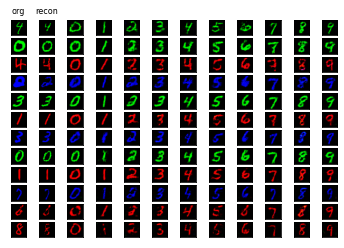

In [12]:
train()
test()
analyze_data()